In [1]:
# autokeras framework
import tensorflow as tf
from keras import backend as K
import autokeras as ak
import keras_tuner

# libraries
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

# graph
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('GPU: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPU:  1


In [3]:
#initial information
path = "C:\\Users\\PV\\OneDrive\\Documents\\ehhhh\\Machine Learning\\data_poll\\"
data_file = pd.read_csv(path +'ys1a.csv')
rd_seed = 173808

data_file.head()

,composition,vec,deltachi,delta,deltahmix,deltasmix,ref,phase,density,hv,testtype,ys,ysmax,elongation,ym,class
0,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,4.0,FCC,8.5,125.0,C,204.0,NaN,NaN,207.0,Al-Co-Cr-Fe-Mn-Ni
1,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,4.0,FCC,8.5,125.0,C,209.0,NaN,NaN,207.0,Al-Co-Cr-Fe-Mn-Ni
2,CoFeNi,9.000000,0.032998,0.327647,-1.333333,9.134371,5.0,FCC,8.5,NaN,T,211.0,513.0,31,207.0,Al-Co-Cr-Fe-Mn-Ni
3,CoFeNiSi0.25,8.615385,0.032490,2.025282,-11.834320,10.686521,4.0,FCC,7.7,149.0,C,196.0,NaN,NaN,194.0,Al-Co-Cr-Fe-Mn-Ni
4,CoFeNiSi0.5,8.285714,0.031944,2.657710,-19.428571,11.239357,4.0,FCC+Im,7.1,287.0,C,476.0,NaN,NaN,NaN,Al-Co-Cr-Fe-Mn-Ni


In [4]:
# preprocess data
'''
    note:
        make a copy of original data
        replace all NA value with N/A for later use
        line 305 has illegal arguemnt ("69, 70"), removed it
        ys is the desired value

'''
data_file = data_file[data_file['ys'].notna()]
data_file = data_file[data_file['phase'].notna()]

data_file.drop(columns= ['composition', 'ref', 'density', 'hv', 'testtype', 'ysmax', 'elongation', 'ym', 'class'], axis=1, inplace=True)

data_file.to_csv(path + "copy_of_ys1a_with_phase.csv", sep=',', na_rep='N/A', index=False)

In [5]:
df = pd.read_csv(path + "copy_of_ys1a_with_phase.csv", quoting=3, index_col=False)
df.head()

,vec,deltachi,delta,deltahmix,deltasmix,phase,ys
0,9.000000,0.032998,0.327647,-1.333333,9.134371,FCC,204.0
1,9.000000,0.032998,0.327647,-1.333333,9.134371,FCC,209.0
2,9.000000,0.032998,0.327647,-1.333333,9.134371,FCC,211.0
3,8.615385,0.032490,2.025282,-11.834320,10.686521,FCC,196.0
4,8.285714,0.031944,2.657710,-19.428571,11.239357,FCC+Im,476.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   vec        198 non-null    float64
 1   deltachi   198 non-null    float64
 2   delta      198 non-null    float64
 3   deltahmix  198 non-null    float64
 4   deltasmix  198 non-null    float64
 5   phase      198 non-null    object 
 6   ys         198 non-null    float64
dtypes: float64(6), object(1)
memory usage: 11.0+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
vec,198.0,6.204930,1.602709,3.350000,4.606121,6.563158,7.500000,10.000000
deltachi,198.0,0.171036,0.082178,0.031383,0.120346,0.141873,0.232682,0.363696
delta,198.0,5.650804,2.472994,0.164560,4.051799,5.777890,6.651869,19.283522
deltahmix,198.0,-9.065072,8.138410,-39.668639,-13.409489,-6.626932,-3.126907,3.500000
deltasmix,198.0,13.267340,1.708432,6.465836,12.525924,13.381611,14.556832,18.268741
ys,198.0,1201.292424,590.430340,140.000000,866.250000,1262.500000,1589.000000,2757.000000


In [8]:
df.corr()

C:\Users\PV\AppData\Local\Temp\ipykernel_17372\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,vec,deltachi,delta,deltahmix,deltasmix,ys
vec,1.000000,-0.417326,-0.264852,-0.093759,-0.014522,-0.445957
deltachi,-0.417326,1.000000,0.359345,0.036366,0.105424,0.261227
delta,-0.264852,0.359345,1.000000,-0.544846,0.363462,0.375523
deltahmix,-0.093759,0.036366,-0.544846,1.000000,-0.371268,-0.290368
deltasmix,-0.014522,0.105424,0.363462,-0.371268,1.000000,0.462587
ys,-0.445957,0.261227,0.375523,-0.290368,0.462587,1.000000


In [9]:
df.dtypes

vec          float64
deltachi     float64
delta        float64
deltahmix    float64
deltasmix    float64
phase         object
ys           float64
dtype: object

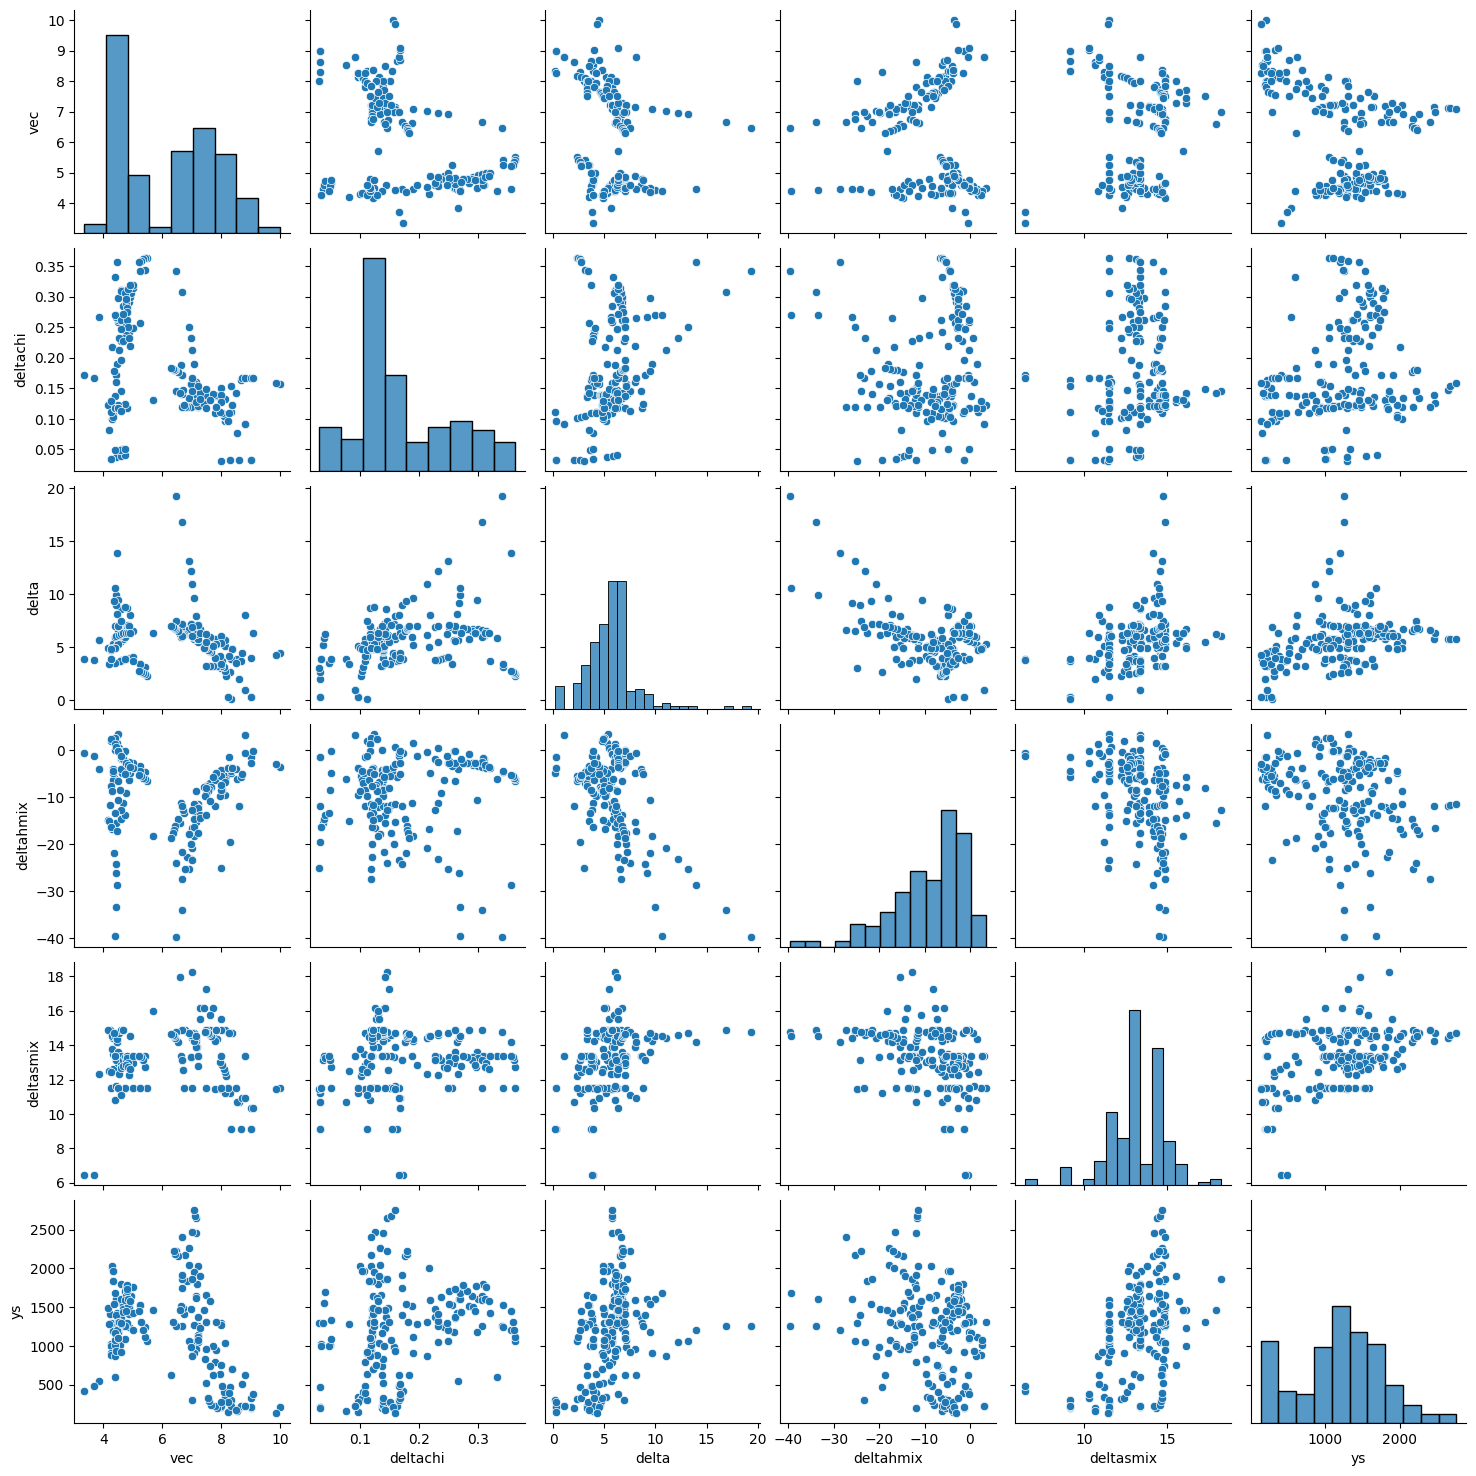

In [10]:
sns.pairplot(df, kind='scatter', diag_kind='hist')
plt.show()

In [11]:
target_col = 'ys'
X = df.loc[:, df.columns != target_col]
y = df.loc[:, target_col]

# change phase into numeric type
pd.options.mode.chained_assignment = None
X['phase'] = LabelEncoder().fit_transform(X['phase'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rd_seed)

print(type(X_train))
print(type(y_train))

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

y_test

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


C:\Users\PV\AppData\Local\Temp\ipykernel_17372\2488509612.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['phase'] = LabelEncoder().fit_transform(X['phase'])


array([1592. , 1301. , 1604. , 1015. , 1365. , 1112. , 1645. , 1298. ,
        488. , 1300. ,  148. , 1965. , 1625. , 1959. , 1188. , 1489. ,
       1251. , 1418. ,  618.8, 1183. , 1305. ,  220. , 1481. ,  318. ,
        200. , 2456. , 1538. , 1469. , 1415. ,  867. , 1603. , 1749. ,
        380. , 1104. , 1461. ,  211. , 1110. , 2179. ,  208. , 1428. ])

In [12]:
rgs = ak.StructuredDataRegressor(
    column_names=[
        'vec',
        'deltachi',
        'delta',
        'deltahmix',
        'deltasmix',
        'phase'
    ],
    column_types={
        'vec': 'numerical', 
        'deltachi': 'numerical', 
        'delta': 'numerical', 
        'deltahmix': 'numerical',
        'deltasmix': 'numerical', 
        'phase': 'categorical'
    },
    project_name='structured_data_regressor_phase',
    max_trials=30,
    objective=keras_tuner.Objective('val_mean_squared_error', direction='min'),
    metrics= [
        'mean_squared_error',
        'mean_absolute_error',
        'mean_absolute_percentage_error'
        ],
    overwrite=True,
    seed=rd_seed
)

rgs.fit(
    X_train, 
    y_train,
    epochs=30,
    validation_split=0.2,
    verbose=0
)

c:\Users\PV\miniconda3\envs\tf\lib\site-packages\keras_tuner\engine\metrics_tracking.py:105: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


INFO:tensorflow:Oracle triggered exit
Epoch 1/30
5/5 [==============================] - 1s 20ms/step - loss: 1791784.5000 - mean_squared_error: 1791784.5000 - mean_absolute_error: 1199.7350 - mean_absolute_percentage_error: 99.9761
Epoch 2/30
5/5 [==============================] - 0s 14ms/step - loss: 1788943.0000 - mean_squared_error: 1788943.0000 - mean_absolute_error: 1198.6152 - mean_absolute_percentage_error: 99.8494
Epoch 3/30
5/5 [==============================] - 0s 16ms/step - loss: 1781954.3750 - mean_squared_error: 1781954.3750 - mean_absolute_error: 1195.9357 - mean_absolute_percentage_error: 99.5388
Epoch 4/30
5/5 [==============================] - 0s 17ms/step - loss: 1763106.8750 - mean_squared_error: 1763106.8750 - mean_absolute_error: 1188.5815 - mean_absolute_percentage_error: 98.7482
Epoch 5/30
5/5 [==============================] - 0s 17ms/step - loss: 1622544.6250 - mean_squared_error: 1622544.6250 - mean_absolute_error: 1135.3387 - mean_absolute_percentage_error: 

In [13]:
y_pred = rgs.predict(X_test)

print("RMSE: ", mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False))
print("MPE: ", mean_absolute_error(y_true=y_test, y_pred=y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))

# evaluate the model
acc = rgs.evaluate(X_test, y_test, verbose=0)
print(acc)

2/2 [==============================] - 0s 5ms/step
RMSE:  485.72964785116807
MPE:  373.8657973098755
MAPE:  0.5107466932452785
[235933.296875, 235933.296875, 373.86578369140625, 51.074668884277344]


In [14]:
y_pred_df = pd.DataFrame(y_pred, columns=['predicted'])
y_true_df = pd.DataFrame(y_test, columns=['true'])

data_as_df = pd.concat([y_true_df, y_pred_df], axis=1)

data_as_df

,true,predicted
0,1592.0,1224.186523
1,1301.0,901.534912
2,1604.0,2181.731445
3,1015.0,1248.414917
4,1365.0,1196.758423
5,1112.0,1486.582397
6,1645.0,1488.817871
7,1298.0,1322.019043
8,488.0,577.365845
9,1300.0,1750.645264


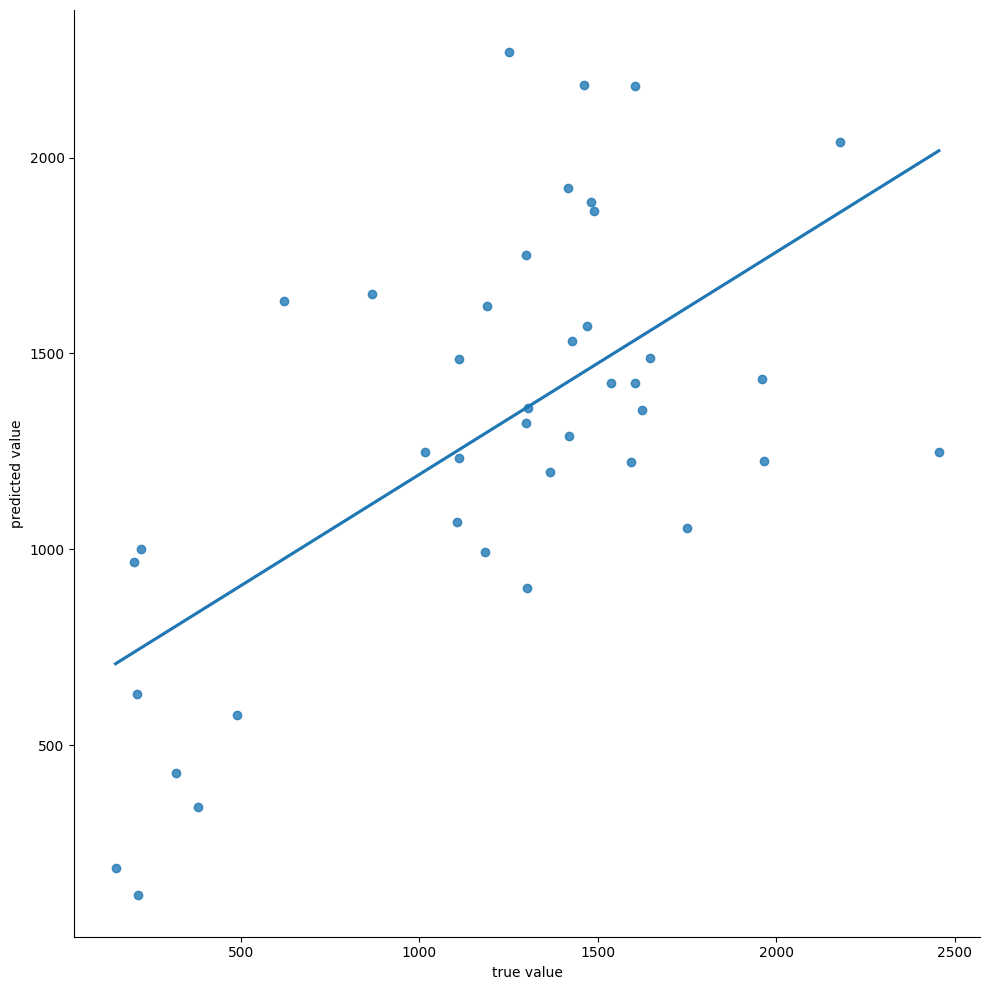

In [15]:
ax = sns.lmplot(x='true', y='predicted', data=data_as_df, height=10, ci=None)
ax.set(xlabel='true value', ylabel='predicted value')

ax